# Extractor Pipeline Debug Notebook

This notebook compares the original working watershed algorithm with the new ExtractorPipeline implementation to identify and fix differences.

In [14]:
# Setup and Data Loading
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import entropy as scipy_entropy
from scipy.ndimage import binary_fill_holes, label as ndi_label, distance_transform_edt
from skimage.segmentation import expand_labels, watershed, find_boundaries
from skimage import morphology
import sys

# Project paths
notebook = Path(r"C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\component development")
project_root = notebook.parent.parent
print(f"Project root: {project_root}")

# Add src to path to import our pipeline
src_path = project_root / "code" / "src"
sys.path.insert(0, str(src_path))
print(f"Added to path: {src_path}")

# Test that we can import our pipeline
try:
    from processing.extractor_pipeline import ExtractorPipeline
    from utils.file_utils import load_as_gray, build_rgb, remove_rectangles
    from utils.image_utils import minmax01
    print("✓ Successfully imported pipeline components")
except ImportError as e:
    print(f"✗ Import failed: {e}")

Project root: C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification
Added to path: C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\src
✓ Successfully imported pipeline components


In [39]:
# Load test image and prepare helper functions
images_root = project_root / 'lysozyme images'
test_red_path = images_root / "Jej LYZ" / "G2" / "G2EL - 3_RFP.tif"
test_blue_path = images_root / "Jej LYZ" / "G2" / "G2EL - 3_DAPI.tif"

print(f"Red path exists: {test_red_path.exists()}")
print(f"Blue path exists: {test_blue_path.exists()}")

# Original notebook helper functions
def load_as_gray_orig(p: Path):
    """Original notebook version"""
    arr = tifffile.imread(p)
    if arr.ndim == 3:
        if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
            arr = np.moveaxis(arr, 0, -1)
        if arr.shape[-1] in (3,4):
            arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
        else:
            arr = arr[...,0]
    return arr.astype(np.float32)

def build_rgb_orig(red_gray, blue_gray):
    """Original notebook version"""
    def to_u8(x):
        if x.dtype != np.uint8:
            lo, hi = np.nanmin(x), np.nanmax(x)
            if hi > lo:
                x = (x - lo)/(hi-lo)*255.0
            else:
                x = np.zeros_like(x)
            return x.astype(np.uint8)
        return x
    r8 = to_u8(red_gray)
    b8 = to_u8(blue_gray)
    zeros = np.zeros_like(r8)
    return np.stack([r8, zeros, b8], axis=-1)

def minmax01_orig(x, eps=1e-12):
    """Original notebook version"""
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

Red path exists: True
Blue path exists: True


In [40]:
# Load and preprocess images - Compare methods
print("=" * 60)
print("COMPARING IMAGE LOADING AND PREPROCESSING")
print("=" * 60)

# Load with original method
r_orig = load_as_gray_orig(test_red_path)
b_orig = load_as_gray_orig(test_blue_path)
print(f"Original method - Red: {r_orig.shape}, range [{r_orig.min():.2f}, {r_orig.max():.2f}]")
print(f"Original method - Blue: {b_orig.shape}, range [{b_orig.min():.2f}, {b_orig.max():.2f}]")

# Load with pipeline method
r_pipeline = load_as_gray(test_red_path)
b_pipeline = load_as_gray(test_blue_path)
print(f"Pipeline method - Red: {r_pipeline.shape}, range [{r_pipeline.min():.2f}, {r_pipeline.max():.2f}]")
print(f"Pipeline method - Blue: {b_pipeline.shape}, range [{b_pipeline.min():.2f}, {b_pipeline.max():.2f}]")

# Check if they're identical
print(f"Red images identical: {np.allclose(r_orig, r_pipeline)}")
print(f"Blue images identical: {np.allclose(b_orig, b_pipeline)}")

# Build RGB with both methods
disp_orig = build_rgb_orig(r_orig, b_orig)
disp_pipeline = build_rgb(r_pipeline, b_pipeline)

print(f"Original RGB: {disp_orig.shape}, dtype {disp_orig.dtype}")
print(f"Pipeline RGB: {disp_pipeline.shape}, dtype {disp_pipeline.dtype}")
print(f"RGB displays identical: {np.allclose(disp_orig, disp_pipeline)}")

# Use original method for the rest (to match notebook exactly)
r = r_orig
b = b_orig
disp = disp_orig

COMPARING IMAGE LOADING AND PREPROCESSING
Original method - Red: (960, 1280), range [3.00, 76.00]
Original method - Blue: (960, 1280), range [3.00, 31.00]
Pipeline method - Red: (960, 1280), range [3.00, 76.00]
Pipeline method - Blue: (960, 1280), range [3.00, 31.00]
Red images identical: True
Blue images identical: True
Original RGB: (960, 1280, 3), dtype uint8
Pipeline RGB: (960, 1280, 3), dtype uint8
RGB displays identical: True


In [41]:
# ORIGINAL NOTEBOOK ALGORITHM (STEP BY STEP)
print("=" * 60)
print("RUNNING ORIGINAL NOTEBOOK ALGORITHM")
print("=" * 60)

# Apply remove_rectangles
try:
    disp = remove_rectangles(disp)
    print("✓ Rectangle removal applied")
except Exception as e:
    print(f"⚠ Rectangle removal failed: {e}")

# Extract red and blue channels from display
red_orig = disp[...,0].astype(np.float32)
blue_orig = disp[...,2].astype(np.float32)
print(f"Red from display: range [{red_orig.min():.2f}, {red_orig.max():.2f}]")
print(f"Blue from display: range [{blue_orig.min():.2f}, {blue_orig.max():.2f}]")

# Morphological operations
mask_r_dilation_orig = np.maximum(blue_orig, red_orig)
mask_r_erosion_orig = np.minimum(blue_orig, red_orig)
print(f"Dilation mask: range [{mask_r_dilation_orig.min():.2f}, {mask_r_dilation_orig.max():.2f}]")
print(f"Erosion mask: range [{mask_r_erosion_orig.min():.2f}, {mask_r_erosion_orig.max():.2f}]")

# diff_r
diff_r_orig = red_orig > mask_r_erosion_orig
print(f"diff_r raw: {np.sum(diff_r_orig)} pixels")

diff_r_orig = morphology.binary_erosion(diff_r_orig, footprint=np.ones((3,3)))
diff_r_orig = morphology.remove_small_objects(diff_r_orig, min_size=100)
print(f"diff_r final: {np.sum(diff_r_orig)} pixels")

# Secondary mask
abs_diff_orig = np.abs(mask_r_dilation_orig - red_orig)
mask_gt_red_orig = abs_diff_orig > red_orig
print(f"abs_diff range: [{abs_diff_orig.min():.2f}, {abs_diff_orig.max():.2f}]")
print(f"mask_gt_red: {np.sum(mask_gt_red_orig)} pixels")

# Erosion
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))
mask_u8 = (mask_gt_red_orig.astype(np.uint8)*255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=2)
mask_gt_red_eroded_orig = mask_eroded_u8.astype(bool)
print(f"mask_gt_red_eroded: {np.sum(mask_gt_red_eroded_orig)} pixels")

# Combined labels
combined_labels_orig = np.zeros_like(diff_r_orig, dtype=int)
combined_labels_orig[mask_gt_red_eroded_orig] = 2
combined_labels_orig[diff_r_orig] = 1
unique_combined = np.unique(combined_labels_orig)
counts = [(label, np.sum(combined_labels_orig == label)) for label in unique_combined]
print(f"Combined labels: {counts}")

RUNNING ORIGINAL NOTEBOOK ALGORITHM
✓ Rectangle removal applied
Red from display: range [0.00, 255.00]
Blue from display: range [0.00, 255.00]
Dilation mask: range [0.00, 255.00]
Erosion mask: range [0.00, 163.00]
diff_r raw: 63787 pixels
diff_r final: 7302 pixels
abs_diff range: [0.00, 190.00]
mask_gt_red: 1045256 pixels
mask_gt_red_eroded: 570879 pixels
Combined labels: [(np.int64(0), np.int64(650619)), (np.int64(1), np.int64(7302)), (np.int64(2), np.int64(570879))]


In [42]:
# Complete original watershed algorithm
print("=" * 60)
print("COMPLETING ORIGINAL WATERSHED ALGORITHM")
print("=" * 60)

# Expand labels
expanded_labels_orig = expand_labels(combined_labels_orig, distance=100)
unique_expanded = np.unique(expanded_labels_orig)
print(f"Expanded labels: {len(unique_expanded)} unique values")
if len(unique_expanded) <= 20:
    print(f"Expanded values: {unique_expanded}")

# Markers from diff_r
labeled_diff_r_orig, _ = ndi_label(diff_r_orig != 0)
print(f"labeled_diff_r: max {labeled_diff_r_orig.max()} regions")

# Reworked markers
reworked_orig = np.zeros_like(expanded_labels_orig, dtype=np.int32)
reworked_orig[expanded_labels_orig == 2] = 1
mask_copy = (expanded_labels_orig != 2) & (labeled_diff_r_orig != 0)
reworked_orig[mask_copy] = labeled_diff_r_orig[mask_copy] + 1
unique_reworked = np.unique(reworked_orig)
print(f"Reworked markers: {len(unique_reworked)} unique, max: {reworked_orig.max()}")

# Watershed mask
mask_ws_orig = expanded_labels_orig > 0
print(f"Watershed mask: {np.sum(mask_ws_orig)} pixels")

# Elevation
elevation_orig = (
    minmax01_orig(distance_transform_edt(combined_labels_orig == 2))
    - minmax01_orig(distance_transform_edt(combined_labels_orig == 1))
)
print(f"Elevation range: [{elevation_orig.min():.3f}, {elevation_orig.max():.3f}]")

# Final watershed
ws_labels_orig = watershed(elevation_orig, markers=reworked_orig, mask=mask_ws_orig)
unique_ws = np.unique(ws_labels_orig)
print(f"Final watershed: {len(unique_ws)} regions, max label: {ws_labels_orig.max()}")
if len(unique_ws) <= 20:
    print(f"Final labels: {unique_ws}")

# Store original results
orig_results = {
    'ws_labels': ws_labels_orig,
    'expanded_labels': expanded_labels_orig,
    'combined_labels': combined_labels_orig,
    'diff_r': diff_r_orig,
    'mask_gt_red_eroded': mask_gt_red_eroded_orig,
    'disp': disp
}

COMPLETING ORIGINAL WATERSHED ALGORITHM
Expanded labels: 3 unique values
Expanded values: [0 1 2]
labeled_diff_r: max 15 regions
Reworked markers: 17 unique, max: 16
Watershed mask: 1035094 pixels
Elevation range: [-1.000, 1.000]
Final watershed: 17 regions, max label: 16
Final labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [43]:
# RUN NEW PIPELINE AND COMPARE
print("=" * 60)
print("RUNNING NEW EXTRACTOR PIPELINE")
print("=" * 60)

# Initialize pipeline with debug
extractor = ExtractorPipeline(debug=True)

# Run pipeline (using original loaded images)
ws_labels_pipeline = extractor.extract(r, b)

print("=" * 60)
print("COMPARING RESULTS")
print("=" * 60)

# Compare final results
print(f"Original final labels: {len(np.unique(orig_results['ws_labels']))} regions, max: {orig_results['ws_labels'].max()}")
print(f"Pipeline final labels: {len(np.unique(ws_labels_pipeline))} regions, max: {ws_labels_pipeline.max()}")
print(f"Final results identical: {np.array_equal(orig_results['ws_labels'], ws_labels_pipeline)}")

# Get debug info
debug_info = extractor.get_debug_info()

# Compare intermediate steps
steps_to_compare = [
    ('diff_r', 'diff_r'),
    ('mask_gt_red_eroded', 'mask_gt_red_eroded'), 
    ('combined_labels', 'combined_labels'),
    ('expanded_labels', 'expanded_labels'),
    ('ws_labels', 'ws_labels')
]

for orig_key, pipeline_key in steps_to_compare:
    if orig_key in orig_results and pipeline_key in debug_info:
        orig_data = orig_results[orig_key]
        pipeline_data = debug_info[pipeline_key]
        identical = np.array_equal(orig_data, pipeline_data)
        print(f"{orig_key:20} identical: {identical}")
        if not identical:
            print(f"  Original unique: {np.unique(orig_data)}")
            print(f"  Pipeline unique: {np.unique(pipeline_data)}")
            if orig_data.dtype == bool:
                print(f"  Original sum: {np.sum(orig_data)}")
                print(f"  Pipeline sum: {np.sum(pipeline_data)}")
    else:
        print(f"{orig_key:20} - Missing data for comparison")

RUNNING NEW EXTRACTOR PIPELINE
[EXTRACTOR DEBUG] Input red: shape (960, 1280), range [3.00, 76.00]
[EXTRACTOR DEBUG] Input blue: shape (960, 1280), range [3.00, 31.00]
[EXTRACTOR DEBUG] Red from display: range [0.00, 255.00]
[EXTRACTOR DEBUG] Blue from display: range [0.00, 255.00]
[EXTRACTOR DEBUG] Dilation mask range: [0.00, 255.00]
[EXTRACTOR DEBUG] Erosion mask range: [0.00, 163.00]
[EXTRACTOR DEBUG] diff_r raw: 63787 pixels
[EXTRACTOR DEBUG] diff_r final: 7302 pixels after erosion and cleanup
[EXTRACTOR DEBUG] abs_diff range: [0.00, 190.00]
[EXTRACTOR DEBUG] mask_gt_red: 1045256 pixels
[EXTRACTOR DEBUG] mask_gt_red_eroded: 570879 pixels
[EXTRACTOR DEBUG] Combined labels: [(np.int64(0), np.int64(650619)), (np.int64(1), np.int64(7302)), (np.int64(2), np.int64(570879))]
[EXTRACTOR DEBUG] Expanded labels: 3 unique values
[EXTRACTOR DEBUG] Expanded values: [0 1 2]
[EXTRACTOR DEBUG] labeled_diff_r: max 15 regions
[EXTRACTOR DEBUG] Reworked markers: 17 unique, max: 16
[EXTRACTOR DEBUG] W

In [44]:
# DETAILED CHANNEL COMPARISON
print("=" * 60)
print("DETAILED CHANNEL ANALYSIS")
print("=" * 60)

# Compare the critical step: channel extraction from RGB
red_orig_extracted = red_orig  # From original: disp[...,0].astype(np.float32)
blue_orig_extracted = blue_orig  # From original: disp[...,2].astype(np.float32)

if 'red_from_disp' in debug_info and 'blue_from_disp' in debug_info:
    red_pipeline_extracted = debug_info['red_from_disp']
    blue_pipeline_extracted = debug_info['blue_from_disp']
    
    print(f"Red channel comparison:")
    print(f"  Original range: [{red_orig_extracted.min():.2f}, {red_orig_extracted.max():.2f}]")
    print(f"  Pipeline range: [{red_pipeline_extracted.min():.2f}, {red_pipeline_extracted.max():.2f}]")
    print(f"  Identical: {np.allclose(red_orig_extracted, red_pipeline_extracted)}")
    
    print(f"Blue channel comparison:")
    print(f"  Original range: [{blue_orig_extracted.min():.2f}, {blue_orig_extracted.max():.2f}]")
    print(f"  Pipeline range: [{blue_pipeline_extracted.min():.2f}, {blue_pipeline_extracted.max():.2f}]")
    print(f"  Identical: {np.allclose(blue_orig_extracted, blue_pipeline_extracted)}")
    
    # Check if the RGB displays are identical
    if 'disp_rgb' in debug_info:
        disp_pipeline = debug_info['disp_rgb']
        print(f"RGB display identical: {np.array_equal(disp, disp_pipeline)}")
        if not np.array_equal(disp, disp_pipeline):
            print(f"  Original RGB range: [{disp.min()}, {disp.max()}]")
            print(f"  Pipeline RGB range: [{disp_pipeline.min()}, {disp_pipeline.max()}]")
else:
    print("⚠ Debug info missing channel data")

# Check morphological operations
if 'mask_r_dilation' in debug_info and 'mask_r_erosion' in debug_info:
    print(f"\nMorphological operations:")
    print(f"  Dilation identical: {np.allclose(mask_r_dilation_orig, debug_info['mask_r_dilation'])}")
    print(f"  Erosion identical: {np.allclose(mask_r_erosion_orig, debug_info['mask_r_erosion'])}")

DETAILED CHANNEL ANALYSIS
Red channel comparison:
  Original range: [0.00, 255.00]
  Pipeline range: [0.00, 255.00]
  Identical: True
Blue channel comparison:
  Original range: [0.00, 255.00]
  Pipeline range: [0.00, 255.00]
  Identical: True
RGB display identical: True

Morphological operations:
  Dilation identical: True
  Erosion identical: True


CREATING COMPARISON VISUALIZATIONS


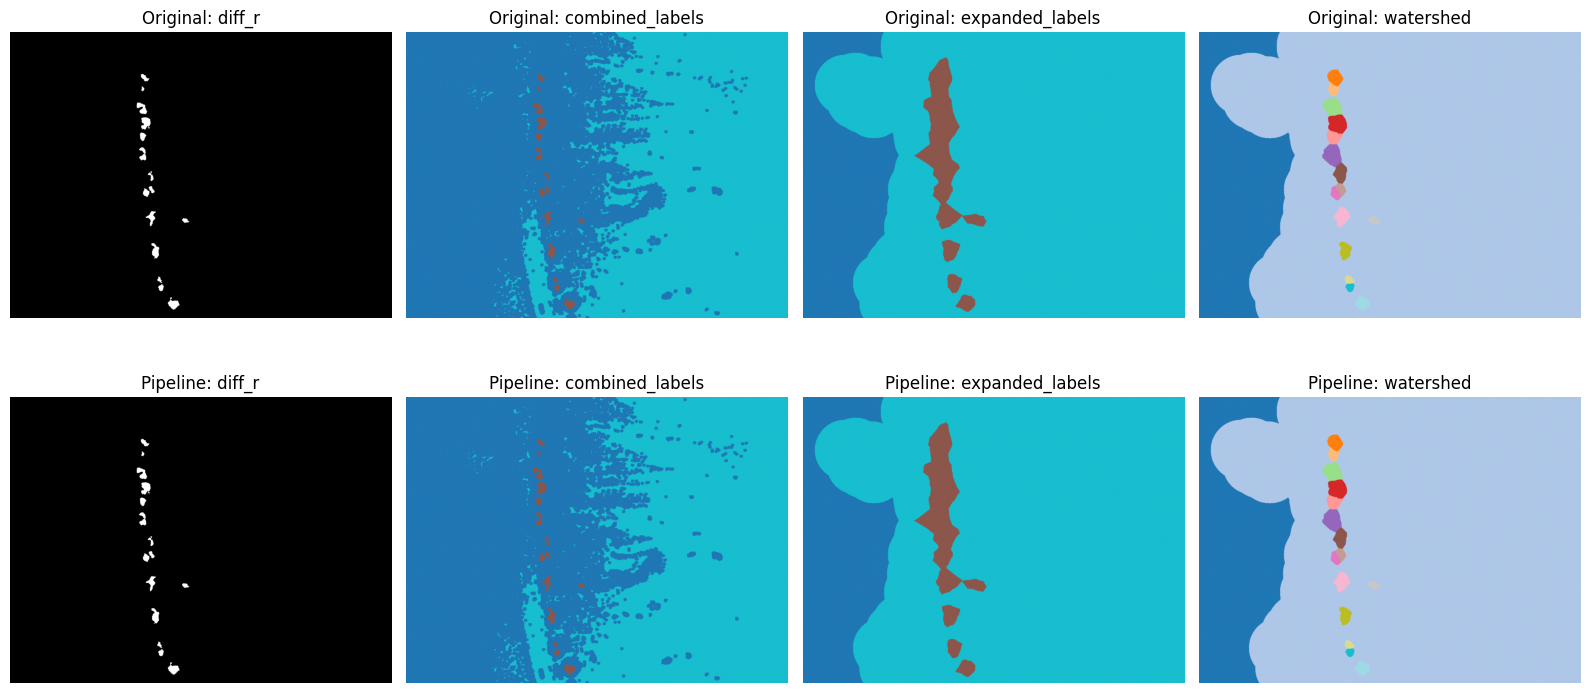

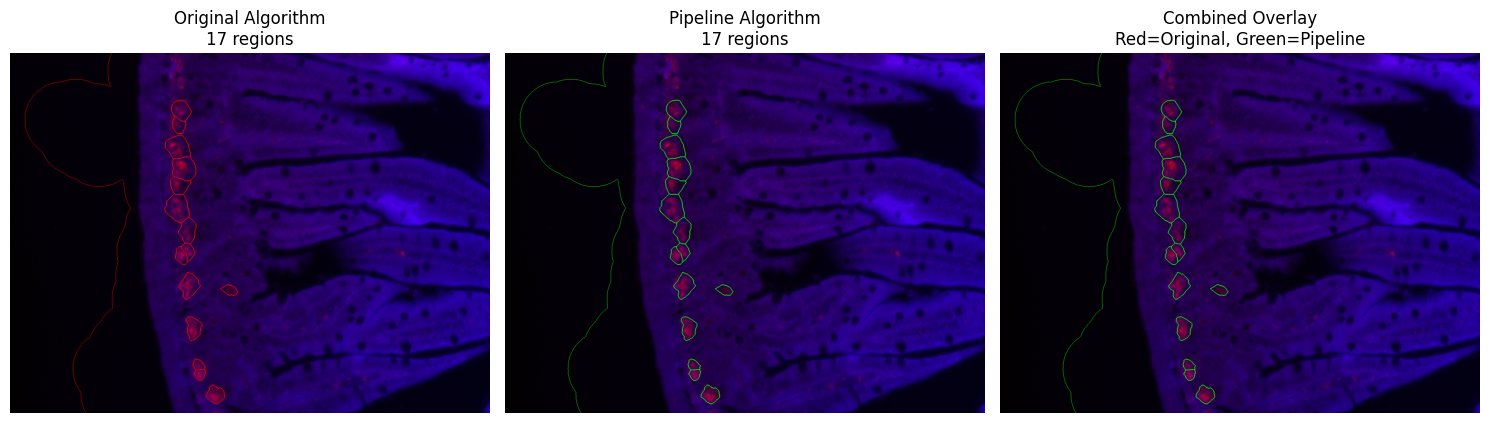

In [45]:
# VISUALIZATION OF RESULTS
print("=" * 60)
print("CREATING COMPARISON VISUALIZATIONS")
print("=" * 60)

# Create side-by-side comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Original algorithm results
row = 0
axes[row, 0].imshow(orig_results['diff_r'], cmap='gray')
axes[row, 0].set_title('Original: diff_r')
axes[row, 0].axis('off')

axes[row, 1].imshow(orig_results['combined_labels'], cmap='tab10')
axes[row, 1].set_title('Original: combined_labels')
axes[row, 1].axis('off')

axes[row, 2].imshow(orig_results['expanded_labels'], cmap='tab10')
axes[row, 2].set_title('Original: expanded_labels')
axes[row, 2].axis('off')

axes[row, 3].imshow(orig_results['ws_labels'], cmap='tab20')
axes[row, 3].set_title('Original: watershed')
axes[row, 3].axis('off')

# Row 2: Pipeline results
row = 1
if 'diff_r' in debug_info:
    axes[row, 0].imshow(debug_info['diff_r'], cmap='gray')
    axes[row, 0].set_title('Pipeline: diff_r')
    axes[row, 0].axis('off')

if 'combined_labels' in debug_info:
    axes[row, 1].imshow(debug_info['combined_labels'], cmap='tab10')
    axes[row, 1].set_title('Pipeline: combined_labels')
    axes[row, 1].axis('off')

if 'expanded_labels' in debug_info:
    axes[row, 2].imshow(debug_info['expanded_labels'], cmap='tab10')
    axes[row, 2].set_title('Pipeline: expanded_labels')
    axes[row, 2].axis('off')

axes[row, 3].imshow(ws_labels_pipeline, cmap='tab20')
axes[row, 3].set_title('Pipeline: watershed')
axes[row, 3].axis('off')

plt.tight_layout()
plt.show()

# Overlay comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original overlay
boundaries_orig = find_boundaries(orig_results['ws_labels'], mode='inner')
overlay_orig = orig_results['disp'].copy()
overlay_orig[boundaries_orig] = [255, 0, 0]

axes[0].imshow(overlay_orig)
axes[0].set_title(f'Original Algorithm\n{len(np.unique(orig_results["ws_labels"]))} regions')
axes[0].axis('off')

# Pipeline overlay
boundaries_pipeline = find_boundaries(ws_labels_pipeline, mode='inner')
overlay_pipeline = orig_results['disp'].copy()
overlay_pipeline[boundaries_pipeline] = [0, 255, 0]

axes[1].imshow(overlay_pipeline)
axes[1].set_title(f'Pipeline Algorithm\n{len(np.unique(ws_labels_pipeline))} regions')
axes[1].axis('off')

# Combined overlay (red=original, green=pipeline)
overlay_combined = orig_results['disp'].copy()
overlay_combined[boundaries_orig] = [255, 0, 0]    # Red for original
overlay_combined[boundaries_pipeline] = [0, 255, 0]  # Green for pipeline

axes[2].imshow(overlay_combined)
axes[2].set_title('Combined Overlay\nRed=Original, Green=Pipeline')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [46]:
# DIAGNOSTIC ANALYSIS
print("=" * 60)
print("DIAGNOSTIC ANALYSIS AND RECOMMENDATIONS")
print("=" * 60)

# Analyze where the differences occur
if not np.array_equal(orig_results['ws_labels'], ws_labels_pipeline):
    print("❌ ALGORITHMS PRODUCE DIFFERENT RESULTS")
    
    # Find first point of divergence
    divergence_found = False
    
    # Check each step
    check_steps = [
        ('red channels', red_orig_extracted, debug_info.get('red_from_disp')),
        ('blue channels', blue_orig_extracted, debug_info.get('blue_from_disp')),
        ('diff_r', orig_results['diff_r'], debug_info.get('diff_r')),
        ('mask_gt_red_eroded', orig_results['mask_gt_red_eroded'], debug_info.get('mask_gt_red_eroded')),
        ('combined_labels', orig_results['combined_labels'], debug_info.get('combined_labels')),
        ('expanded_labels', orig_results['expanded_labels'], debug_info.get('expanded_labels')),
        ('final_labels', orig_results['ws_labels'], ws_labels_pipeline)
    ]
    
    for step_name, orig_data, pipeline_data in check_steps:
        if orig_data is not None and pipeline_data is not None:
            if isinstance(orig_data, np.ndarray) and isinstance(pipeline_data, np.ndarray):
                if not np.array_equal(orig_data, pipeline_data):
                    print(f"🔍 DIVERGENCE FOUND at: {step_name}")
                    print(f"   Original shape: {orig_data.shape}, dtype: {orig_data.dtype}")
                    print(f"   Pipeline shape: {pipeline_data.shape}, dtype: {pipeline_data.dtype}")
                    if orig_data.dtype == bool:
                        print(f"   Original True pixels: {np.sum(orig_data)}")
                        print(f"   Pipeline True pixels: {np.sum(pipeline_data)}")
                    else:
                        print(f"   Original unique values: {len(np.unique(orig_data))}")
                        print(f"   Pipeline unique values: {len(np.unique(pipeline_data))}")
                        print(f"   Original range: [{orig_data.min()}, {orig_data.max()}]")
                        print(f"   Pipeline range: [{pipeline_data.min()}, {pipeline_data.max()}]")
                    divergence_found = True
                    break
                else:
                    print(f"✓ {step_name}: IDENTICAL")
            else:
                print(f"⚠ {step_name}: Cannot compare (type mismatch)")
        else:
            print(f"⚠ {step_name}: Missing data")
    
    if not divergence_found:
        print("🤔 No clear divergence point found - may be floating point precision issue")

else:
    print("✅ ALGORITHMS PRODUCE IDENTICAL RESULTS!")

# Summary statistics
print(f"\nSUMMARY:")
print(f"Original algorithm found: {len(np.unique(orig_results['ws_labels']))} regions")
print(f"Pipeline algorithm found: {len(np.unique(ws_labels_pipeline))} regions")
print(f"Test image: {test_red_path.name}")

DIAGNOSTIC ANALYSIS AND RECOMMENDATIONS
✅ ALGORITHMS PRODUCE IDENTICAL RESULTS!

SUMMARY:
Original algorithm found: 17 regions
Pipeline algorithm found: 17 regions
Test image: G2EL - 3_RFP.tif


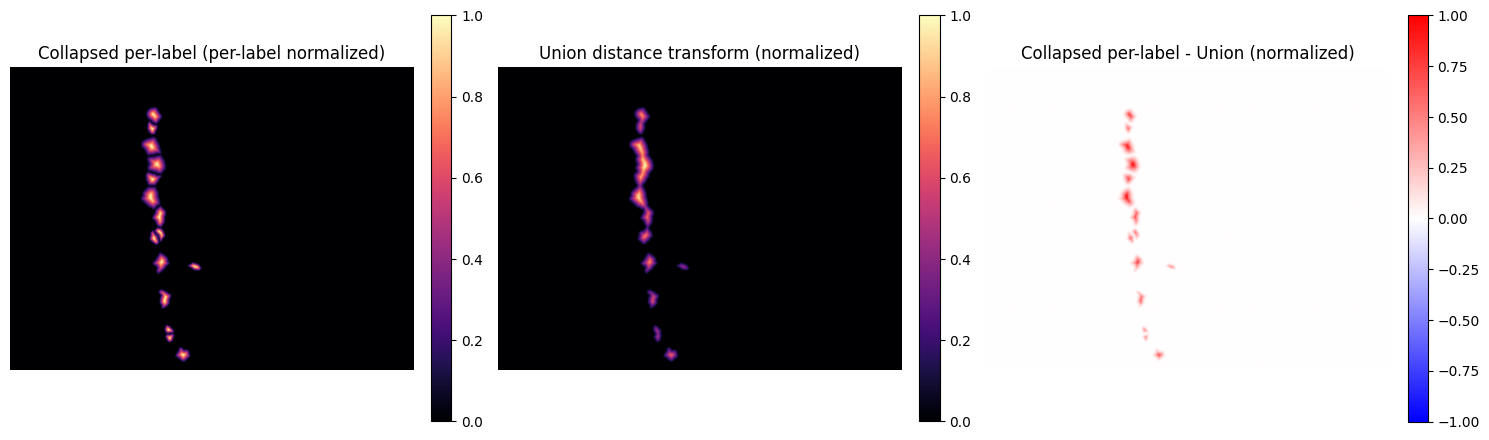

In [52]:
# set all labels equal to 1 to 0 (in-place)
ws_labels_pipeline[ws_labels_pipeline == 1] = 0
#plt.imshow(ws_labels_pipeline)
# Distance transforms per-label and for all non-zero labels together


# Distance transforms per-label, union, and collapsed visualization

labels = np.unique(ws_labels_pipeline)
labels = labels[labels != 0]  # exclude background

h, w = ws_labels_pipeline.shape
dt_collapsed = np.zeros((h, w), dtype=float)   # will hold per-label normalized distances, collapsed
dt_per_label_max = {}                            # store max distance per label (optional)
dt_maps = {}                                     # store raw dt maps per label (optional)

if len(labels) == 0:
    print("No non-zero labels found in ws_labels_pipeline.")
else:
    for lab in labels:
        mask = (ws_labels_pipeline == lab)
        if not np.any(mask):
            continue
        # distance inside the label to the label boundary (distance to nearest False)
        dt = distance_transform_edt(mask)
        dt_maps[lab] = dt
        m = dt.max()
        dt_per_label_max[lab] = m
        if m > 0:
            dt_norm = dt / m   # normalize per-label so every label uses full dynamic range
        else:
            dt_norm = dt
        # collapse: keep normalized distances only where the label is present
        dt_collapsed[mask] = dt_norm[mask]

# union distance transform (all non-zero labels together)
union_mask = (ws_labels_pipeline != 0)
if np.any(union_mask):
    dt_union = distance_transform_edt(union_mask)
    # normalize for visualization
    dt_union_norm = dt_union / (dt_union.max() if dt_union.max() > 0 else 1.0)
else:
    dt_union = np.zeros_like(ws_labels_pipeline, dtype=float)
    dt_union_norm = dt_union

# Visualize collapsed per-label DT and union DT side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im0 = axes[0].imshow(dt_collapsed, cmap='magma')
axes[0].set_title('Collapsed per-label (per-label normalized)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(dt_union_norm, cmap='magma')
axes[1].set_title('Union distance transform (normalized)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Difference (useful to spot where per-label normalization hides absolute differences)
# compute per-pixel difference between per-label normalized collapsed and union normalized
diff = dt_collapsed * dt_union_norm
im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
axes[2].set_title('Collapsed per-label - Union (normalized)')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()




Pixels with ws_labels_pipeline > 0: 27369
Distance stats (over masked pixels):
  dt_union_norm -> mean: 0.1569, median: 0.1215, max: 0.7213
  dt_collapsed  -> mean: 0.1772, median: 0.1279, max: 0.7722
  Pixels where dt_union closer: 14358 (52.46%)
  Pixels where dt_collapsed closer: 13011 (47.54%)
  Ties (nearly equal): 0 (0.00%)


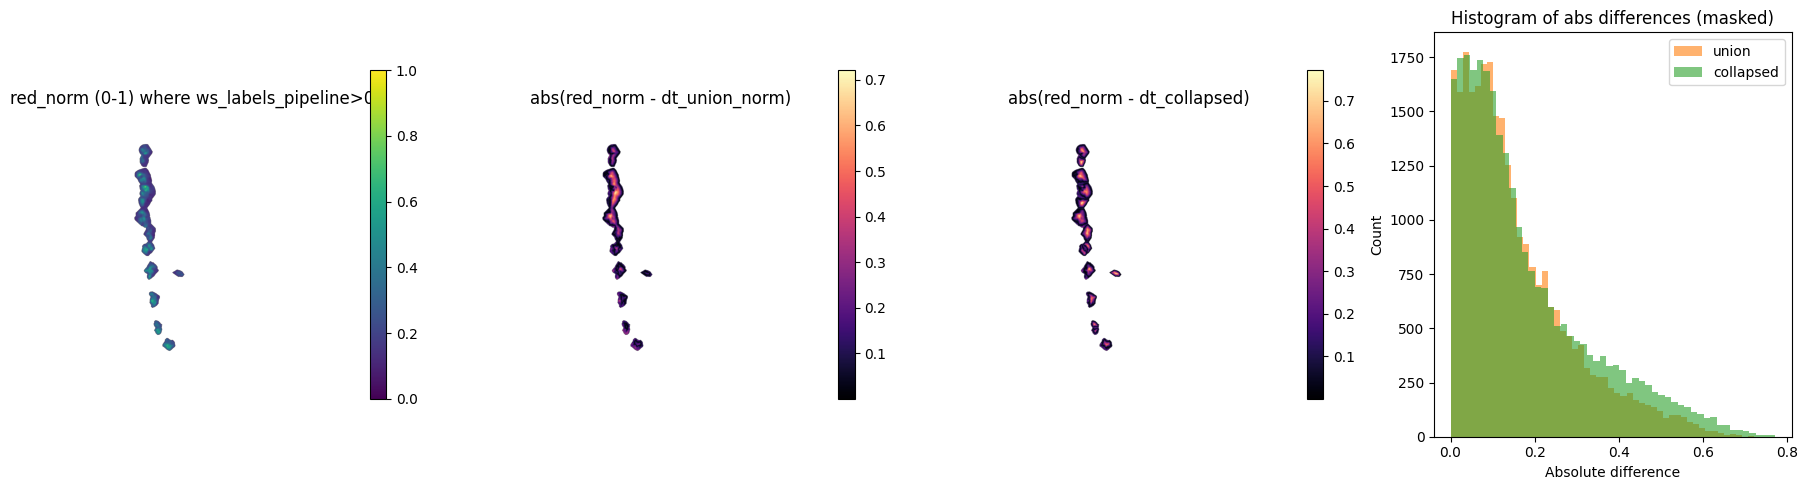

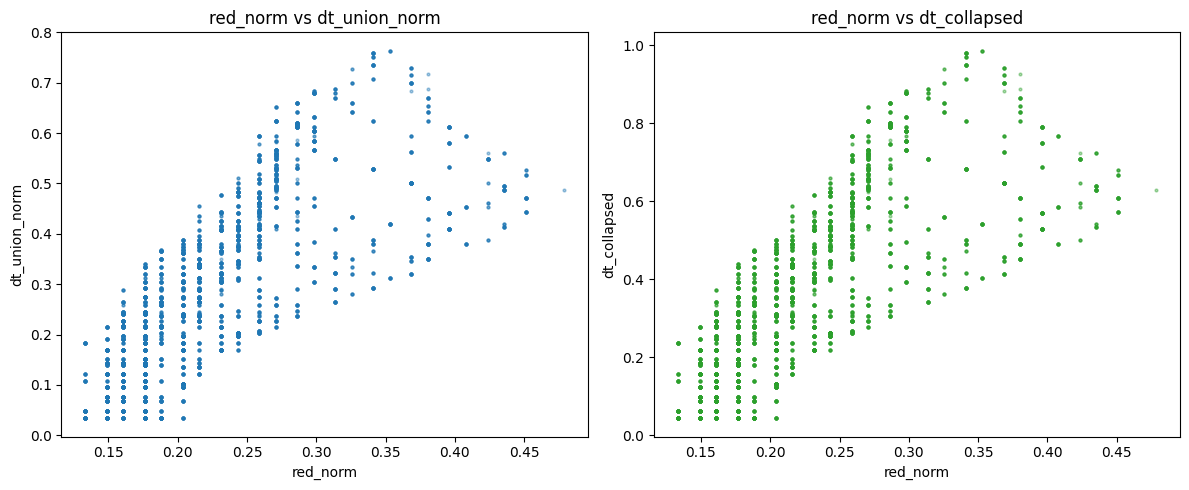

In [58]:
# Normalize red_orig_extracted to 0-1 and compare distances to dt_union_norm vs dt_collapsed
mask = (ws_labels_pipeline > 0)
n_pixels = int(np.count_nonzero(mask))
print(f"Pixels with ws_labels_pipeline > 0: {n_pixels}")

if n_pixels == 0:
    print("No pixels found where ws_labels_pipeline > 0.")
else:
    eps = 1e-12
    red = red_orig_extracted.astype(float, copy=False)
    lo, hi = red.min(), red.max()
    red_norm = (red - lo) / max(hi - lo, eps)        # global 0-1 normalization

    # Ensure dt maps are present and same shape
    assert dt_union_norm.shape == red_norm.shape == dt_collapsed.shape, "Shape mismatch"

    # Per-pixel absolute distances
    abs_diff_union = np.abs(red_norm - dt_union_norm)
    abs_diff_collapsed = np.abs(red_norm - dt_collapsed)

    # Stats over masked pixels
    union_vals = abs_diff_union[mask]
    collapsed_vals = abs_diff_collapsed[mask]
    print("Distance stats (over masked pixels):")
    print(f"  dt_union_norm -> mean: {union_vals.mean():.4f}, median: {np.median(union_vals):.4f}, max: {union_vals.max():.4f}")
    print(f"  dt_collapsed  -> mean: {collapsed_vals.mean():.4f}, median: {np.median(collapsed_vals):.4f}, max: {collapsed_vals.max():.4f}")

    # Which is closer per-pixel
    closer_union = (union_vals < collapsed_vals)
    closer_collapsed = (collapsed_vals < union_vals)
    ties = np.isclose(union_vals, collapsed_vals, atol=1e-9)
    print(f"  Pixels where dt_union closer: {closer_union.sum()} ({100*closer_union.mean():.2f}%)")
    print(f"  Pixels where dt_collapsed closer: {closer_collapsed.sum()} ({100*closer_collapsed.mean():.2f}%)")
    print(f"  Ties (nearly equal): {ties.sum()} ({100*ties.mean():.2f}%)")

    # Visualize: normalized red, and absolute difference maps (masked)
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    mred = np.ma.masked_where(~mask, red_norm)
    im0 = axes[0].imshow(mred, cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title('red_norm (0-1) where ws_labels_pipeline>0')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    md1 = np.ma.masked_where(~mask, abs_diff_union)
    im1 = axes[1].imshow(md1, cmap='magma')
    axes[1].set_title('abs(red_norm - dt_union_norm)')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    md2 = np.ma.masked_where(~mask, abs_diff_collapsed)
    im2 = axes[2].imshow(md2, cmap='magma')
    axes[2].set_title('abs(red_norm - dt_collapsed)')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    # Histogram comparison of absolute differences
    axes[3].hist(union_vals.ravel(), bins=50, alpha=0.6, label='union', color='C1', density=False)
    axes[3].hist(collapsed_vals.ravel(), bins=50, alpha=0.6, label='collapsed', color='C2', density=False)
    axes[3].set_title('Histogram of abs differences (masked)')
    axes[3].legend()
    axes[3].set_xlabel('Absolute difference')
    axes[3].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Optional: scatter (sample points to avoid huge plot)
    sample_idx = np.nonzero(mask)[0]
    if sample_idx.size > 5000:
        rng = np.random.default_rng(0)
        choice = rng.choice(sample_idx, size=5000, replace=False)
    else:
        choice = sample_idx
    # flatten indices and sample
    ys, xs = np.nonzero(mask)
    sel_y = ys if ys.size <= 5000 else ys[choice]
    sel_x = xs if xs.size <= 5000 else xs[choice]
    sel_red = red_norm[sel_y, sel_x]
    sel_du = dt_union_norm[sel_y, sel_x]
    sel_dc = dt_collapsed[sel_y, sel_x]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(sel_red, sel_du, s=4, alpha=0.4)
    ax[0].set_xlabel('red_norm')
    ax[0].set_ylabel('dt_union_norm')
    ax[0].set_title('red_norm vs dt_union_norm')

    ax[1].scatter(sel_red, sel_dc, s=4, alpha=0.4, color='C2')
    ax[1].set_xlabel('red_norm')
    ax[1].set_ylabel('dt_collapsed')
    ax[1].set_title('red_norm vs dt_collapsed')

    plt.tight_layout()
    plt.show()

DISTANCE-BASED MERGING ANALYSIS
Merging benefit range: [-0.5696, 0.5742]
Pixels where merging would help: 14358 (52.46%)
Mean benefit where positive: 0.1088
Mean penalty where negative: -0.0773


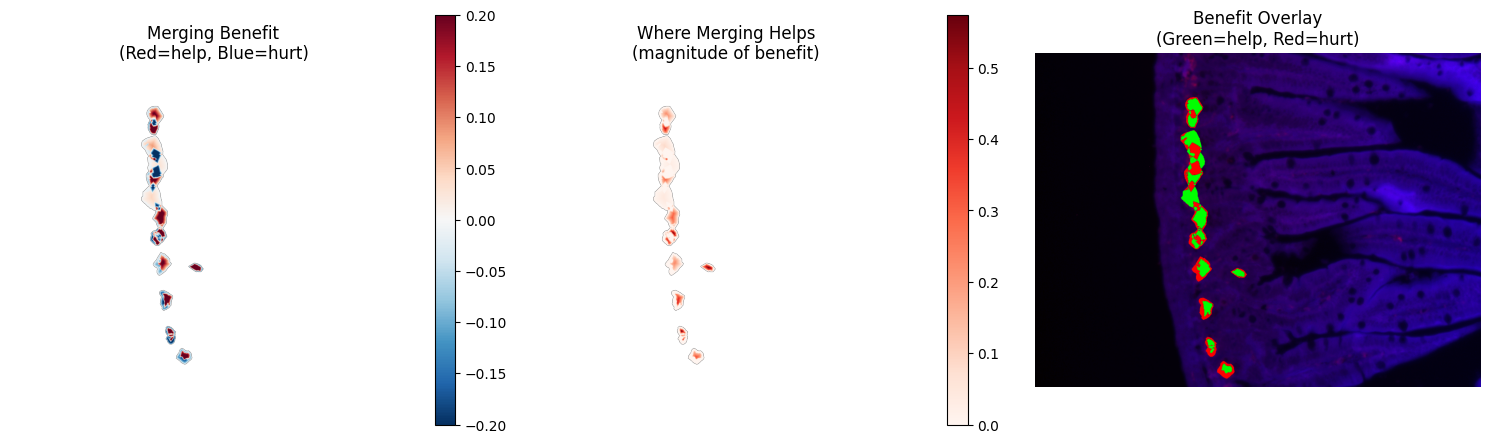

In [71]:
# Explore using distance transform differences for merging decisions
print("=" * 60)
print("DISTANCE-BASED MERGING ANALYSIS")
print("=" * 60)

# The key insight: 
# - dt_union_norm represents what the distance would be if regions were merged
# - dt_collapsed represents current per-label normalized distances
# - red_norm is the actual intensity we're trying to match
# - If red_norm is closer to dt_union_norm than dt_collapsed, merging might improve the fit

# Create a "merging benefit" metric per pixel
# Positive values = merging would improve fit to red intensity
# Negative values = merging would worsen fit
merging_benefit = abs_diff_collapsed - abs_diff_union
print(f"Merging benefit range: [{merging_benefit.min():.4f}, {merging_benefit.max():.4f}]")

# Stats over masked pixels
mask = (ws_labels_pipeline > 0)
benefit_vals = merging_benefit[mask]
positive_benefit = benefit_vals > 0
print(f"Pixels where merging would help: {positive_benefit.sum()} ({100*positive_benefit.mean():.2f}%)")
print(f"Mean benefit where positive: {benefit_vals[positive_benefit].mean():.4f}")
print(f"Mean penalty where negative: {benefit_vals[~positive_benefit].mean():.4f}")

# Visualize merging benefit map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show raw merging benefit (masked)
masked_benefit = np.ma.masked_where(~mask, merging_benefit)
im0 = axes[0].imshow(masked_benefit, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
axes[0].set_title('Merging Benefit\n(Red=help, Blue=hurt)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Show only positive benefits (where merging helps)
positive_benefit_map = np.where(merging_benefit > 0, merging_benefit, 0)
masked_positive = np.ma.masked_where(~mask, positive_benefit_map)
im1 = axes[1].imshow(masked_positive, cmap='Reds')
axes[1].set_title('Where Merging Helps\n(magnitude of benefit)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Overlay on original image
overlay_benefit = disp.copy()
# Color pixels where merging would help in green
help_pixels = (merging_benefit > 0.01) & mask  # threshold for significance
overlay_benefit[help_pixels] = [0, 255, 0]
# Color pixels where merging would hurt in red
hurt_pixels = (merging_benefit < -0.01) & mask
overlay_benefit[hurt_pixels] = [255, 0, 0]

axes[2].imshow(overlay_benefit)
axes[2].set_title('Benefit Overlay\n(Green=help, Red=hurt)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [76]:
# Comprehensive Distance-Based Merging with Consensus Voting
print("=" * 80)
print("COMPREHENSIVE DISTANCE-BASED MERGING WITH CONSENSUS VOTING")
print("=" * 80)

from itertools import combinations
from collections import defaultdict
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import binary_dilation

def find_adjacent_regions(labels_array):
    """Find all pairs of adjacent regions using boundary analysis."""
    from skimage.segmentation import find_boundaries
    
    # Find boundaries and dilate to catch adjacencies
    boundaries = find_boundaries(labels_array, mode='inner')
    boundary_dilated = binary_dilation(boundaries, structure=np.ones((3,3)))
    
    # Find pairs of adjacent labels
    adjacent_pairs = set()
    for y in range(labels_array.shape[0]):
        for x in range(labels_array.shape[1]):
            if boundary_dilated[y, x]:
                # Check 3x3 neighborhood for different labels
                y_min, y_max = max(0, y-1), min(labels_array.shape[0], y+2)
                x_min, x_max = max(0, x-1), min(labels_array.shape[1], x+2)
                
                local_labels = np.unique(labels_array[y_min:y_max, x_min:x_max])
                local_labels = local_labels[local_labels != 0]  # exclude background
                
                # Add all pairs
                for i, label1 in enumerate(local_labels):
                    for label2 in local_labels[i+1:]:
                        if label1 != label2:
                            adjacent_pairs.add((min(label1, label2), max(label1, label2)))
    
    return adjacent_pairs

def build_adjacency_graph(adjacent_pairs):
    """Build a graph of adjacent regions."""
    G = nx.Graph()
    for label1, label2 in adjacent_pairs:
        G.add_edge(label1, label2)
    return G

def generate_region_combinations(G, max_group_size=4):
    """Generate all possible combinations of connected regions up to max_group_size."""
    combinations_dict = {}
    
    # Individual regions
    for node in G.nodes():
        combinations_dict[frozenset([node])] = [node]
    
    # Pairs and larger connected groups
    for group_size in range(2, max_group_size + 1):
        for component in nx.connected_components(G):
            if len(component) >= group_size:
                # Generate all combinations of this size within this connected component
                for combo in combinations(component, group_size):
                    combo_set = frozenset(combo)
                    # Check if this combination forms a connected subgraph
                    subgraph = G.subgraph(combo)
                    if nx.is_connected(subgraph):
                        combinations_dict[combo_set] = list(combo)
    
    return combinations_dict

def compute_distance_transform_for_group(labels_array, region_group):
    """Compute normalized distance transform for a group of regions."""
    # Create mask for the group
    group_mask = np.zeros_like(labels_array, dtype=bool)
    for label_id in region_group:
        group_mask |= (labels_array == label_id)
    
    if not np.any(group_mask):
        return np.zeros_like(labels_array, dtype=float), 0
    
    # Compute distance transform
    dt = distance_transform_edt(group_mask)
    
    # Normalize to 0-1
    max_dt = dt.max()
    if max_dt > 0:
        dt_norm = dt / max_dt
    else:
        dt_norm = dt
    
    return dt_norm, max_dt

def compute_fit_quality(dt_norm, red_norm, region_group, labels_array):
    """Compute fit quality between distance transform and red channel for the group."""
    # Create mask for the group
    group_mask = np.zeros_like(labels_array, dtype=bool)
    for label_id in region_group:
        group_mask |= (labels_array == label_id)
    
    if not np.any(group_mask):
        return float('inf'), 0
    
    # Extract values only within the group
    dt_vals = dt_norm[group_mask]
    red_vals = red_norm[group_mask]
    
    # Compute mean absolute error
    mae = np.mean(np.abs(dt_vals - red_vals))
    n_pixels = len(dt_vals)
    
    return mae, n_pixels

# Step 1: Find adjacent regions
print("Step 1: Finding adjacent regions...")
adjacent_pairs = find_adjacent_regions(ws_labels_pipeline)
print(f"Found {len(adjacent_pairs)} adjacent pairs")

# Step 2: Build adjacency graph
print("Step 2: Building adjacency graph...")
G = build_adjacency_graph(adjacent_pairs)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Connected components: {nx.number_connected_components(G)}")

# Step 3: Generate all possible combinations
print("Step 3: Generating region combinations...")
max_group_size = 3  # Limit to avoid combinatorial explosion
region_combinations = generate_region_combinations(G, max_group_size)
print(f"Generated {len(region_combinations)} total combinations:")
for size in range(1, max_group_size + 1):
    size_count = sum(1 for combo in region_combinations.keys() if len(combo) == size)
    print(f"  Size {size}: {size_count} combinations")

# Step 4: Compute distance transforms and fit qualities for all combinations
print("Step 4: Computing distance transforms and fit qualities...")
fit_results = {}
distance_transforms = {}

for combo_key, region_group in region_combinations.items():
    # Compute distance transform for this group
    dt_norm, max_dt = compute_distance_transform_for_group(ws_labels_pipeline, region_group)
    distance_transforms[combo_key] = dt_norm
    
    # Compute fit quality
    mae, n_pixels = compute_fit_quality(dt_norm, red_norm, region_group, ws_labels_pipeline)
    
    fit_results[combo_key] = {
        'regions': region_group,
        'mae': mae,
        'n_pixels': n_pixels,
        'max_dt': max_dt,
        'group_size': len(region_group)
    }

print(f"Computed fits for {len(fit_results)} combinations")

COMPREHENSIVE DISTANCE-BASED MERGING WITH CONSENSUS VOTING
Step 1: Finding adjacent regions...
Found 8 adjacent pairs
Step 2: Building adjacency graph...
Graph has 11 nodes and 8 edges
Connected components: 3
Step 3: Generating region combinations...
Generated 24 total combinations:
  Size 1: 11 combinations
  Size 2: 8 combinations
  Size 3: 5 combinations
Step 4: Computing distance transforms and fit qualities...
Computed fits for 24 combinations


In [77]:
# Step 5: Rank all options for each region and implement consensus voting
print("Step 5: Ranking options and implementing consensus voting...")

# Create ranking for each region
region_rankings = defaultdict(list)  # region_id -> [(combo_key, mae, rank), ...]

# For each region, find all combinations it's part of and rank them by fit quality
for combo_key, result in fit_results.items():
    for region_id in result['regions']:
        region_rankings[region_id].append((combo_key, result['mae'], result['group_size']))

# Sort rankings by MAE (lower is better)
for region_id in region_rankings:
    region_rankings[region_id].sort(key=lambda x: x[1])
    # Add rank information
    region_rankings[region_id] = [(combo, mae, size, rank) for rank, (combo, mae, size) in enumerate(region_rankings[region_id])]

print(f"Generated rankings for {len(region_rankings)} regions")

# Show top choices for a few regions
print("\nTop 3 choices for first 5 regions:")
for region_id in list(region_rankings.keys())[:5]:
    print(f"\nRegion {region_id}:")
    top_choices = region_rankings[region_id][:3]
    for combo, mae, size, rank in top_choices:
        regions_in_combo = fit_results[combo]['regions']
        print(f"  Rank {rank+1}: {regions_in_combo} (MAE: {mae:.4f}, Size: {size})")

# Step 6: Implement consensus-based merging
def check_consensus_for_merge(combo_key, region_rankings, fit_results):
    """Check if all regions in a combination agree it's their best option."""
    regions_in_combo = fit_results[combo_key]['regions']
    
    if len(regions_in_combo) <= 1:
        return True, "Single region"
    
    consensus_info = {}
    all_agree = True
    
    for region_id in regions_in_combo:
        # Find the rank of this combination for this region
        rankings = region_rankings[region_id]
        combo_rank = None
        for combo, mae, size, rank in rankings:
            if combo == combo_key:
                combo_rank = rank
                break
        
        # Check if this is the best multi-region option for this region
        best_multi_rank = None
        for combo, mae, size, rank in rankings:
            if fit_results[combo]['group_size'] > 1:
                best_multi_rank = rank
                break
        
        is_best_multi = (combo_rank == best_multi_rank)
        consensus_info[region_id] = {
            'combo_rank': combo_rank,
            'best_multi_rank': best_multi_rank,
            'is_best_multi': is_best_multi
        }
        
        if not is_best_multi:
            all_agree = False
    
    return all_agree, consensus_info

print("\nStep 6: Checking consensus for multi-region combinations...")

# Find all multi-region combinations where all members agree
consensus_merges = []
consensus_details = {}

for combo_key, result in fit_results.items():
    if result['group_size'] > 1:  # Only check multi-region combinations
        all_agree, consensus_info = check_consensus_for_merge(combo_key, region_rankings, fit_results)
        
        consensus_details[combo_key] = {
            'all_agree': all_agree,
            'consensus_info': consensus_info,
            'mae': result['mae'],
            'regions': result['regions'],
            'group_size': result['group_size']
        }
        
        if all_agree:
            consensus_merges.append(combo_key)

print(f"Found {len(consensus_merges)} combinations with full consensus")

# Show consensus results
if len(consensus_merges) > 0:
    print("\nConsensus merges (all regions agree):")
    for combo_key in consensus_merges:
        details = consensus_details[combo_key]
        print(f"  {details['regions']} -> MAE: {details['mae']:.4f}")
else:
    print("\nNo full consensus merges found.")

# Show near-consensus (most regions agree)
print("\nNear-consensus analysis (showing top 5 multi-region combinations):")
near_consensus = []
for combo_key, details in consensus_details.items():
    if details['group_size'] > 1:
        agreeing_count = sum(1 for info in details['consensus_info'].values() if info['is_best_multi'])
        agreement_fraction = agreeing_count / details['group_size']
        near_consensus.append((combo_key, agreement_fraction, details['mae'], details['regions']))

near_consensus.sort(key=lambda x: (-x[1], x[2]))  # Sort by agreement fraction desc, then MAE asc

for combo_key, agreement_frac, mae, regions in near_consensus[:5]:
    print(f"  {regions}: {agreement_frac*100:.1f}% agree, MAE: {mae:.4f}")
    # Show which regions agree/disagree
    details = consensus_details[combo_key]
    for region_id, info in details['consensus_info'].items():
        status = "✓" if info['is_best_multi'] else "✗"
        print(f"    Region {region_id}: {status} (rank {info['combo_rank']+1} of multi-region options)")

print(f"\nOverall summary:")
print(f"  Total regions: {len(region_rankings)}")
print(f"  Total combinations evaluated: {len(fit_results)}")
print(f"  Multi-region combinations: {sum(1 for r in fit_results.values() if r['group_size'] > 1)}")
print(f"  Full consensus merges: {len(consensus_merges)}")

# Save results for potential implementation
consensus_merge_results = {
    'fit_results': fit_results,
    'region_rankings': region_rankings,
    'consensus_merges': consensus_merges,
    'consensus_details': consensus_details,
    'distance_transforms': distance_transforms
}

Step 5: Ranking options and implementing consensus voting...
Generated rankings for 11 regions

Top 3 choices for first 5 regions:

Region 9:
  Rank 1: [np.int32(9), np.int32(10)] (MAE: 0.1476, Size: 2)
  Rank 2: [np.int32(7), np.int32(8), np.int32(9)] (MAE: 0.1611, Size: 3)
  Rank 3: [np.int32(9)] (MAE: 0.1661, Size: 1)

Region 10:
  Rank 1: [np.int32(10)] (MAE: 0.1416, Size: 1)
  Rank 2: [np.int32(9), np.int32(10)] (MAE: 0.1476, Size: 2)
  Rank 3: [np.int32(8), np.int32(9), np.int32(10)] (MAE: 0.1756, Size: 3)

Region 2:
  Rank 1: [np.int32(2)] (MAE: 0.1784, Size: 1)
  Rank 2: [np.int32(2), np.int32(3)] (MAE: 0.1973, Size: 2)

Region 3:
  Rank 1: [np.int32(2), np.int32(3)] (MAE: 0.1973, Size: 2)
  Rank 2: [np.int32(3)] (MAE: 0.2208, Size: 1)

Region 6:
  Rank 1: [np.int32(6), np.int32(7), np.int32(8)] (MAE: 0.1656, Size: 3)
  Rank 2: [np.int32(6), np.int32(7)] (MAE: 0.1744, Size: 2)
  Rank 3: [np.int32(6)] (MAE: 0.1816, Size: 1)

Step 6: Checking consensus for multi-region combinatio

VISUALIZING CONSENSUS-BASED MERGING RESULTS


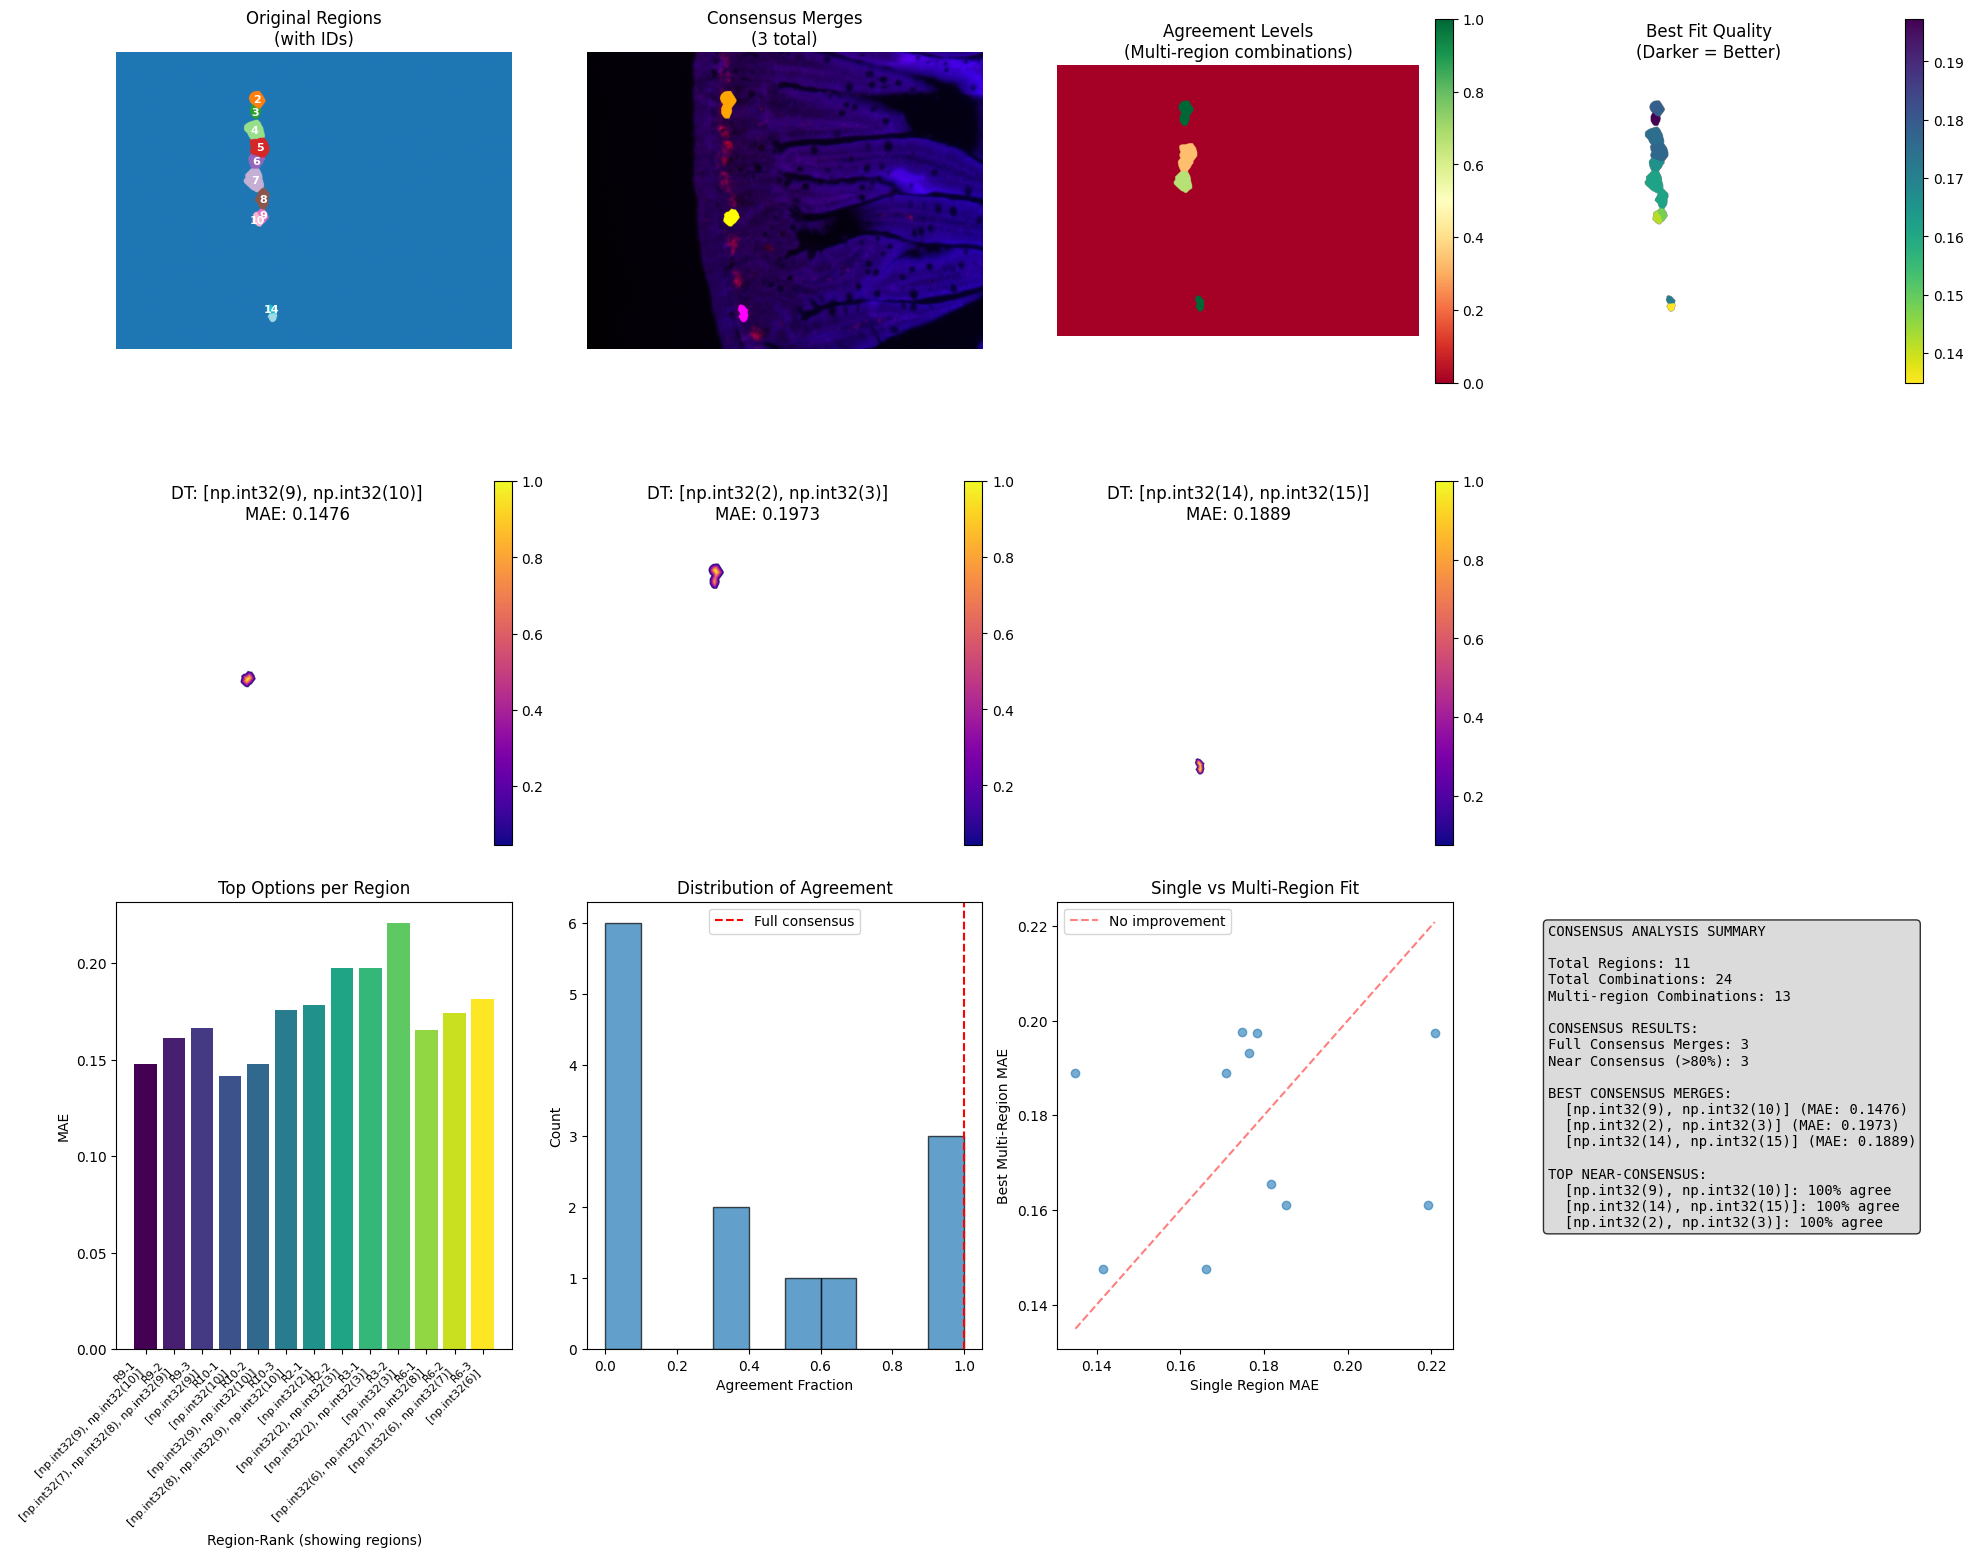

Visualization complete!


In [79]:
# Step 7: Comprehensive Visualization of Consensus Results
print("=" * 80)
print("VISUALIZING CONSENSUS-BASED MERGING RESULTS")
print("=" * 80)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# 1. Original segmentation with region IDs
ax1 = plt.subplot(3, 4, 1)
original_viz = np.zeros_like(ws_labels_pipeline, dtype=float)
for i, region_id in enumerate(region_rankings.keys()):
    original_viz[ws_labels_pipeline == region_id] = region_id
im1 = ax1.imshow(original_viz, cmap='tab20')
ax1.set_title('Original Regions\n(with IDs)')
ax1.axis('off')

# Add region ID annotations
for region_id in list(region_rankings.keys())[:10]:  # Only show first 10 to avoid clutter
    region_mask = (ws_labels_pipeline == region_id)
    if np.any(region_mask):
        ys, xs = np.where(region_mask)
        center_y, center_x = np.mean(ys), np.mean(xs)
        ax1.text(center_x, center_y, str(region_id), color='white', 
                fontsize=8, ha='center', va='center', weight='bold')

# 2. Consensus merges overlay
ax2 = plt.subplot(3, 4, 2)
consensus_overlay = disp.copy()

# Color code different types of consensus
colors = [(255, 255, 0), (255, 165, 0), (255, 0, 255), (0, 255, 255)]  # Yellow, Orange, Magenta, Cyan
for i, combo_key in enumerate(consensus_merges[:4]):  # Show up to 4 consensus merges
    color = colors[i % len(colors)]
    regions_in_combo = fit_results[combo_key]['regions']
    for region_id in regions_in_combo:
        region_mask = (ws_labels_pipeline == region_id)
        consensus_overlay[region_mask] = color

ax2.imshow(consensus_overlay)
ax2.set_title(f'Consensus Merges\n({len(consensus_merges)} total)')
ax2.axis('off')

# 3. Near-consensus visualization (color by agreement percentage)
ax3 = plt.subplot(3, 4, 3)
agreement_viz = np.zeros_like(ws_labels_pipeline, dtype=float)

for combo_key, details in consensus_details.items():
    if details['group_size'] > 1:
        regions_in_combo = details['regions']
        agreeing_count = sum(1 for info in details['consensus_info'].values() if info['is_best_multi'])
        agreement_fraction = agreeing_count / details['group_size']
        
        for region_id in regions_in_combo:
            region_mask = (ws_labels_pipeline == region_id)
            agreement_viz[region_mask] = agreement_fraction

im3 = ax3.imshow(agreement_viz, cmap='RdYlGn', vmin=0, vmax=1)
ax3.set_title('Agreement Levels\n(Multi-region combinations)')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

# 4. Fit quality heatmap
ax4 = plt.subplot(3, 4, 4)
best_mae_viz = np.full_like(ws_labels_pipeline, np.nan, dtype=float)

for region_id in region_rankings.keys():
    # Get the best MAE for this region
    best_mae = region_rankings[region_id][0][1]  # First ranking has best MAE
    region_mask = (ws_labels_pipeline == region_id)
    best_mae_viz[region_mask] = best_mae

masked_mae = np.ma.masked_invalid(best_mae_viz)
im4 = ax4.imshow(masked_mae, cmap='viridis_r')  # Reversed so darker = better fit
ax4.set_title('Best Fit Quality\n(Darker = Better)')
ax4.axis('off')
plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)

# 5-8. Show individual distance transforms for some consensus merges
for i, combo_key in enumerate(consensus_merges[:4]):
    ax = plt.subplot(3, 4, 5 + i)
    
    if combo_key in distance_transforms:
        dt_viz = distance_transforms[combo_key]
        regions_in_combo = fit_results[combo_key]['regions']
        
        # Mask to show only the regions in this combination
        combo_mask = np.zeros_like(ws_labels_pipeline, dtype=bool)
        for region_id in regions_in_combo:
            combo_mask |= (ws_labels_pipeline == region_id)
        
        masked_dt = np.ma.masked_where(~combo_mask, dt_viz)
        im = ax.imshow(masked_dt, cmap='plasma')
        ax.set_title(f'DT: {regions_in_combo}\nMAE: {fit_results[combo_key]["mae"]:.4f}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# 9. Region ranking comparison (bar chart)
ax9 = plt.subplot(3, 4, 9)
if len(region_rankings) > 0:
    # Show ranking comparison for a few regions
    sample_regions = list(region_rankings.keys())[:5]
    mae_data = []
    labels = []
    
    for region_id in sample_regions:
        rankings = region_rankings[region_id][:3]  # Top 3 options
        for rank, (combo, mae, size, _) in enumerate(rankings):
            mae_data.append(mae)
            combo_regions = fit_results[combo]['regions']
            labels.append(f'R{region_id}-{rank+1}\n{combo_regions}')
    
    x_pos = np.arange(len(labels))
    bars = ax9.bar(x_pos, mae_data, color=plt.cm.viridis(np.linspace(0, 1, len(mae_data))))
    ax9.set_xlabel('Region-Rank (showing regions)')
    ax9.set_ylabel('MAE')
    ax9.set_title('Top Options per Region')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)

# 10. Agreement distribution histogram
ax10 = plt.subplot(3, 4, 10)
agreement_fractions = []
for combo_key, details in consensus_details.items():
    if details['group_size'] > 1:
        agreeing_count = sum(1 for info in details['consensus_info'].values() if info['is_best_multi'])
        agreement_fraction = agreeing_count / details['group_size']
        agreement_fractions.append(agreement_fraction)

if agreement_fractions:
    ax10.hist(agreement_fractions, bins=10, alpha=0.7, edgecolor='black')
    ax10.axvline(x=1.0, color='red', linestyle='--', label='Full consensus')
    ax10.set_xlabel('Agreement Fraction')
    ax10.set_ylabel('Count')
    ax10.set_title('Distribution of Agreement')
    ax10.legend()

# 11. MAE improvement analysis
ax11 = plt.subplot(3, 4, 11)
mae_improvements = []
single_maes = []
multi_maes = []

for region_id in region_rankings.keys():
    rankings = region_rankings[region_id]
    single_mae = None
    best_multi_mae = None
    
    for combo, mae, size, rank in rankings:
        if size == 1 and single_mae is None:
            single_mae = mae
        elif size > 1 and best_multi_mae is None:
            best_multi_mae = mae
    
    if single_mae is not None and best_multi_mae is not None:
        improvement = single_mae - best_multi_mae  # Positive = multi is better
        mae_improvements.append(improvement)
        single_maes.append(single_mae)
        multi_maes.append(best_multi_mae)

if mae_improvements:
    ax11.scatter(single_maes, multi_maes, alpha=0.6)
    # Add diagonal line (no improvement)
    min_mae, max_mae = min(single_maes + multi_maes), max(single_maes + multi_maes)
    ax11.plot([min_mae, max_mae], [min_mae, max_mae], 'r--', alpha=0.5, label='No improvement')
    ax11.set_xlabel('Single Region MAE')
    ax11.set_ylabel('Best Multi-Region MAE')
    ax11.set_title('Single vs Multi-Region Fit')
    ax11.legend()

# 12. Summary statistics
ax12 = plt.subplot(3, 4, 12)
ax12.axis('off')

# Create summary text
summary_text = f"""CONSENSUS ANALYSIS SUMMARY

Total Regions: {len(region_rankings)}
Total Combinations: {len(fit_results)}
Multi-region Combinations: {sum(1 for r in fit_results.values() if r['group_size'] > 1)}

CONSENSUS RESULTS:
Full Consensus Merges: {len(consensus_merges)}
Near Consensus (>80%): {sum(1 for combo_key, details in consensus_details.items() 
                            if details['group_size'] > 1 and 
                            sum(1 for info in details['consensus_info'].values() if info['is_best_multi']) / details['group_size'] > 0.8)}

BEST CONSENSUS MERGES:"""

if consensus_merges:
    for combo_key in consensus_merges[:3]:
        details = consensus_details[combo_key]
        summary_text += f"\n  {details['regions']} (MAE: {details['mae']:.4f})"
else:
    summary_text += "\n  None found"

if near_consensus:
    summary_text += f"\n\nTOP NEAR-CONSENSUS:"
    for combo_key, agreement_frac, mae, regions in near_consensus[:3]:
        summary_text += f"\n  {regions}: {agreement_frac*100:.0f}% agree"

ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes, fontsize=10,
          verticalalignment='top', fontfamily='monospace',
          bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("Visualization complete!")

IMPLEMENTING CONSENSUS-BASED MERGING
Merge 1: [np.int32(9), np.int32(10)] -> 9 (MAE: 0.1476)
Merge 2: [np.int32(14), np.int32(15)] -> 14 (MAE: 0.1889)
Merge 3: [np.int32(2), np.int32(3)] -> 2 (MAE: 0.1973)

Merging complete!
Original regions: 15
Final regions: 12
Merges applied: 3


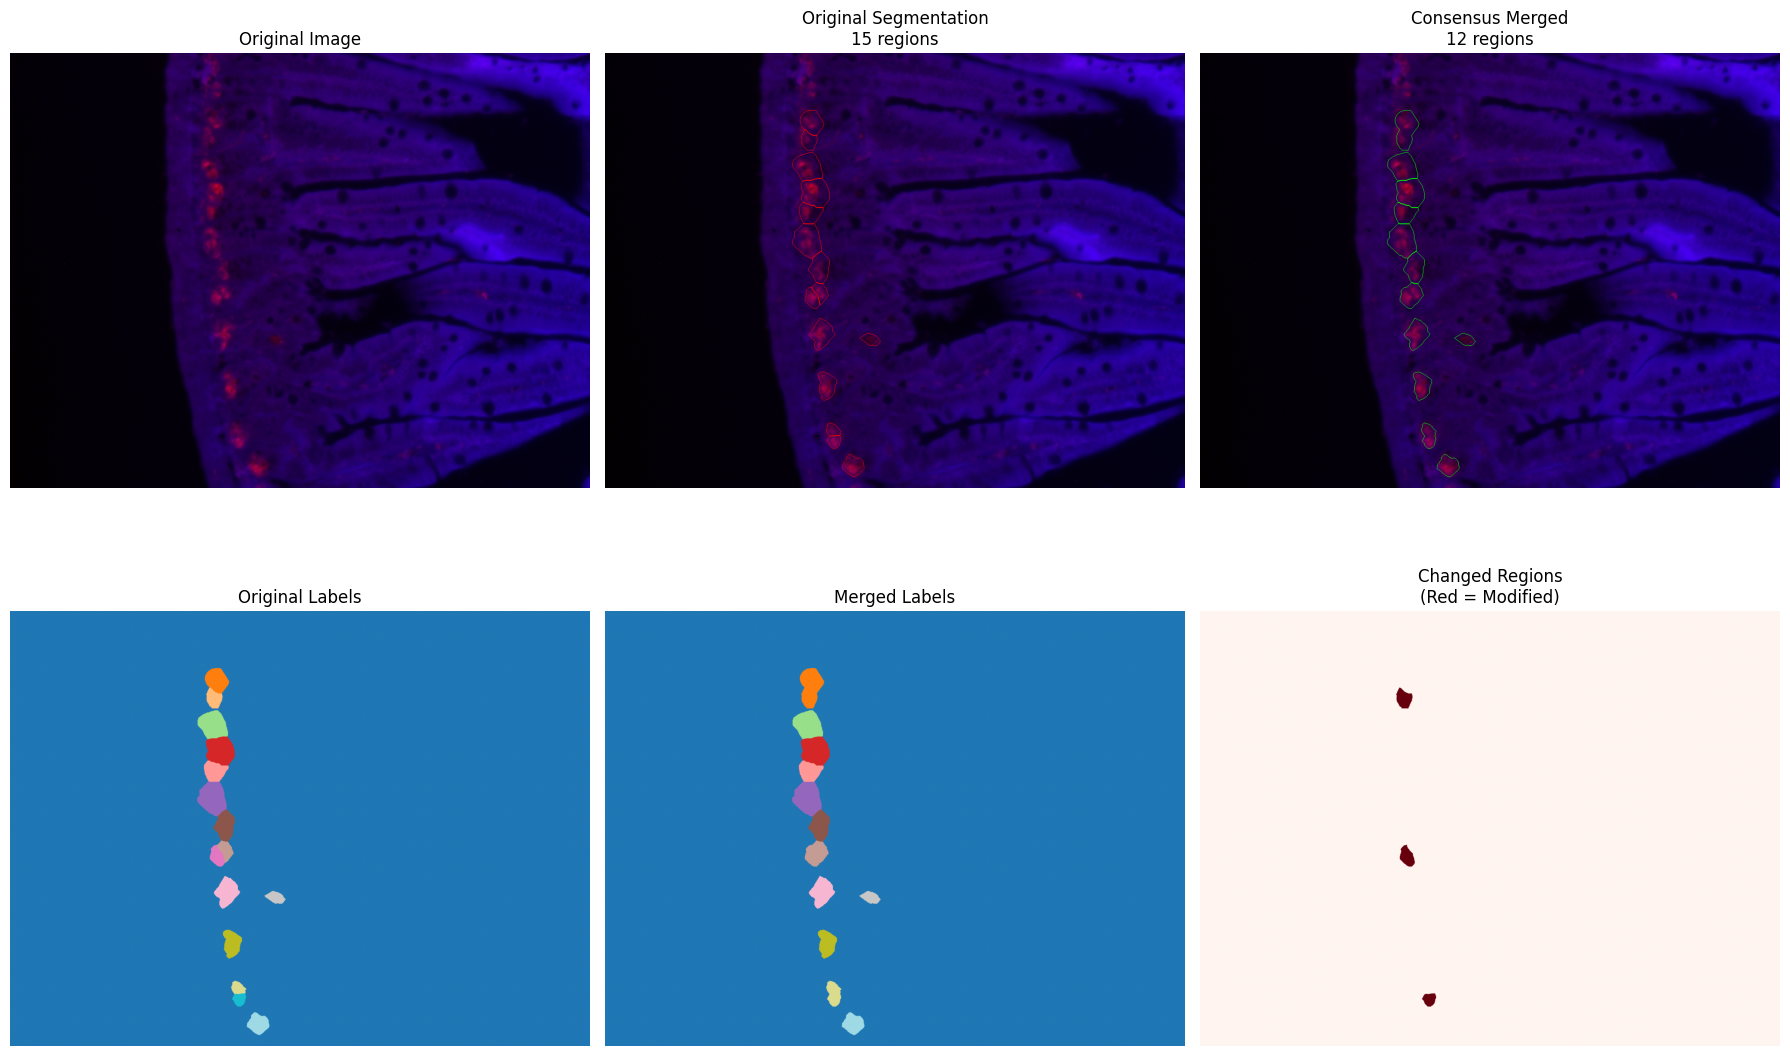


Detailed Merge Log:
------------------------------------------------------------
Merge 1: [np.int32(9), np.int32(10)] -> 9
  MAE: 0.1476
  Pixels affected: 2049
Merge 2: [np.int32(14), np.int32(15)] -> 14
  MAE: 0.1889
  Pixels affected: 1359
Merge 3: [np.int32(2), np.int32(3)] -> 2
  MAE: 0.1973
  Pixels affected: 3237

Total pixels affected: 6645 (24.3% of segmented area)

Quality Assessment:
----------------------------------------
Original average MAE: 0.1772
Merged average MAE: 0.1790
Improvement: -0.0018 (-1.0%)
⚠ Consensus merging did not improve overall fit quality

Final summary:
  Regions reduced from 15 to 12
  Reduction: 20.0%
  Fit quality change: -1.0%


In [81]:
# Step 8: Implement Consensus-Based Merging
print("=" * 80)
print("IMPLEMENTING CONSENSUS-BASED MERGING")
print("=" * 80)

def apply_consensus_merges(labels_array, consensus_merges, fit_results):
    """Apply consensus merges to create final merged labels."""
    merged_labels = labels_array.copy()
    merge_log = []
    
    # Sort consensus merges by MAE (best first)
    sorted_merges = sorted(consensus_merges, key=lambda x: fit_results[x]['mae'])
    
    for i, combo_key in enumerate(sorted_merges):
        regions_to_merge = fit_results[combo_key]['regions']
        mae = fit_results[combo_key]['mae']
        
        # Check if all regions are still available (not already merged)
        available_regions = []
        for region_id in regions_to_merge:
            if np.any(merged_labels == region_id):
                available_regions.append(region_id)
        
        if len(available_regions) == len(regions_to_merge):
            # All regions available - proceed with merge
            target_label = min(regions_to_merge)  # Use smallest label as target
            
            for region_id in regions_to_merge:
                if region_id != target_label:
                    merged_labels[merged_labels == region_id] = target_label
            
            merge_log.append({
                'merge_id': i + 1,
                'regions': regions_to_merge,
                'target_label': target_label,
                'mae': mae,
                'pixels_affected': sum(np.sum(labels_array == rid) for rid in regions_to_merge)
            })
            
            print(f"Merge {i+1}: {regions_to_merge} -> {target_label} (MAE: {mae:.4f})")
        else:
            print(f"Skipped merge {regions_to_merge}: some regions already merged")
    
    return merged_labels, merge_log

# Apply consensus merges
final_merged_labels, merge_log = apply_consensus_merges(ws_labels_pipeline, consensus_merges, fit_results)

print(f"\nMerging complete!")
print(f"Original regions: {len(np.unique(ws_labels_pipeline)) - 1}")  # -1 for background
print(f"Final regions: {len(np.unique(final_merged_labels)) - 1}")     # -1 for background
print(f"Merges applied: {len(merge_log)}")

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Before and After comparison
axes[0, 0].imshow(disp)
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Original segmentation with boundaries
boundaries_orig = find_boundaries(ws_labels_pipeline, mode='inner')
overlay_orig = disp.copy()
overlay_orig[boundaries_orig] = [255, 0, 0]
axes[0, 1].imshow(overlay_orig)
axes[0, 1].set_title(f'Original Segmentation\n{len(np.unique(ws_labels_pipeline)) - 1} regions')
axes[0, 1].axis('off')

# Final merged segmentation with boundaries
boundaries_merged = find_boundaries(final_merged_labels, mode='inner')
overlay_merged = disp.copy()
overlay_merged[boundaries_merged] = [0, 255, 0]
axes[0, 2].imshow(overlay_merged)
axes[0, 2].set_title(f'Consensus Merged\n{len(np.unique(final_merged_labels)) - 1} regions')
axes[0, 2].axis('off')

# Row 2: Analysis visualizations
# Show which regions were merged
axes[1, 0].imshow(ws_labels_pipeline, cmap='tab20')
axes[1, 0].set_title('Original Labels')
axes[1, 0].axis('off')

axes[1, 1].imshow(final_merged_labels, cmap='tab20')
axes[1, 1].set_title('Merged Labels')
axes[1, 1].axis('off')

# Difference map showing what changed
change_map = (ws_labels_pipeline != final_merged_labels).astype(float)
axes[1, 2].imshow(change_map, cmap='Reds')
axes[1, 2].set_title('Changed Regions\n(Red = Modified)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Show detailed merge statistics
if merge_log:
    print("\nDetailed Merge Log:")
    print("-" * 60)
    total_pixels_affected = 0
    for merge in merge_log:
        print(f"Merge {merge['merge_id']}: {merge['regions']} -> {merge['target_label']}")
        print(f"  MAE: {merge['mae']:.4f}")
        print(f"  Pixels affected: {merge['pixels_affected']}")
        total_pixels_affected += merge['pixels_affected']
    
    total_pixels = np.sum(ws_labels_pipeline > 0)
    print(f"\nTotal pixels affected: {total_pixels_affected} ({100*total_pixels_affected/total_pixels:.1f}% of segmented area)")

# Evaluate the quality improvement
print("\nQuality Assessment:")
print("-" * 40)

# Compare fit quality before and after merging
original_mae_total = 0
merged_mae_total = 0
total_pixels = 0

for region_id in np.unique(ws_labels_pipeline):
    if region_id == 0:  # Skip background
        continue
    
    region_mask = (ws_labels_pipeline == region_id)
    n_pixels = np.sum(region_mask)
    total_pixels += n_pixels
    
    # Original fit (individual region)
    dt_orig = distance_transform_edt(region_mask)
    if dt_orig.max() > 0:
        dt_orig_norm = dt_orig / dt_orig.max()
    else:
        dt_orig_norm = dt_orig
    
    red_vals = red_norm[region_mask]
    dt_vals = dt_orig_norm[region_mask]
    original_mae = np.mean(np.abs(red_vals - dt_vals))
    original_mae_total += original_mae * n_pixels

# Merged fit
for region_id in np.unique(final_merged_labels):
    if region_id == 0:  # Skip background
        continue
    
    region_mask = (final_merged_labels == region_id)
    n_pixels = np.sum(region_mask)
    
    # Merged fit
    dt_merged = distance_transform_edt(region_mask)
    if dt_merged.max() > 0:
        dt_merged_norm = dt_merged / dt_merged.max()
    else:
        dt_merged_norm = dt_merged
    
    red_vals = red_norm[region_mask]
    dt_vals = dt_merged_norm[region_mask]
    merged_mae = np.mean(np.abs(red_vals - dt_vals))
    merged_mae_total += merged_mae * n_pixels

original_mae_avg = original_mae_total / total_pixels
merged_mae_avg = merged_mae_total / total_pixels
improvement = original_mae_avg - merged_mae_avg

print(f"Original average MAE: {original_mae_avg:.4f}")
print(f"Merged average MAE: {merged_mae_avg:.4f}")
print(f"Improvement: {improvement:.4f} ({100*improvement/original_mae_avg:.1f}%)")

if improvement > 0:
    print("✓ Consensus merging improved fit quality!")
else:
    print("⚠ Consensus merging did not improve overall fit quality")

print(f"\nFinal summary:")
print(f"  Regions reduced from {len(np.unique(ws_labels_pipeline)) - 1} to {len(np.unique(final_merged_labels)) - 1}")
print(f"  Reduction: {100 * len(merge_log) / (len(np.unique(ws_labels_pipeline)) - 1):.1f}%")
print(f"  Fit quality change: {100*improvement/original_mae_avg:.1f}%")